# Example of loading a multi-resolution Zarr image from a public S3 repository

The images are taken from  the paper "SARS-CoV-2 productively Infects Human Gut Enterocytes" published May 2020 in Science: https://doi.org/10.1126/science.abc1669

The electron micrograph images can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=dataset-10201). Both images are over 13 gigapixels each!
- [hSIOs-1 (79360 x 167424 px, image ID 9822151)](https://idr.openmicroscopy.org/webclient/img_detail/9822151/?dataset=10201)
- [hSIOs-2 (144384 x 93184 px, image ID 9822152)](https://idr.openmicroscopy.org/webclient/img_detail/9822152/?dataset=10201)

In [1]:
import dask.array as da
from IPython.display import display, Image
from matplotlib import pyplot as plt
import requests
import zarr

The Zarr data is stored separately from the IDR, on an S3 object store

In [2]:
# imageid = 9822151
imageid = 9822152

endpoint = 'https://s3.embassy.ebi.ac.uk'
imagepath = f'idr/zarr/v0.1/{imageid}.zarr'

The original image is over 25GB but with the help of [Dask](https://dask.org/) it is easy to lazily load just the required regions of the image.

Images are stored as 5D arrays: multi-channel (`C`) 3D (`X Y Z`) timelapse (`T`) images. The order of the array dimensions are `(T, C, Z, Y, X)`. Since these images are so big downsampled versions ("multi-resolutions") have also been calculated.

The list of resolutions is stored in a JSON file called `.zattrs`. Dask automatically creates a nice summary of each resolution in Jupyter. These resolutions will always be stored in order from the largest image (most detailed resolution) to the smallest. Note that although the name of each resolution may be informative this is not always the case so you should not rely on it.

For the official specification of Zarr images see https://github.com/ome/omero-ms-zarr/blob/master/spec.md

In [3]:
def da_from_image(resolution):
    return da.from_zarr(f'{endpoint}/{imagepath}/{resolution}')

zattrs = requests.get(f'{endpoint}/{imagepath}/.zattrs').json()
resolutions = [d['path'] for d in zattrs['multiscales'][0]['datasets']]

darrays = {}
for resolution in resolutions:
    print(f'Resolution: "{resolution}"')
    a = da_from_image(resolution)
    darrays[resolution] = a
    display(a)

Resolution: "0"


dask.array<from-zarr, shape=(1, 1, 1, 93184, 144384), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "1"


dask.array<from-zarr, shape=(1, 1, 1, 46592, 72192), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "2"


dask.array<from-zarr, shape=(1, 1, 1, 23296, 36096), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "3"


dask.array<from-zarr, shape=(1, 1, 1, 11648, 18048), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "4"


dask.array<from-zarr, shape=(1, 1, 1, 5824, 9024), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "5"


dask.array<from-zarr, shape=(1, 1, 1, 2912, 4512), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "6"


dask.array<from-zarr, shape=(1, 1, 1, 1456, 2256), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

Resolution: "7"


dask.array<from-zarr, shape=(1, 1, 1, 728, 1128), dtype=>u2, chunksize=(1, 1, 1, 728, 1024), chunktype=numpy.ndarray>

Resolution: "8"


dask.array<from-zarr, shape=(1, 1, 1, 364, 564), dtype=>u2, chunksize=(1, 1, 1, 364, 564), chunktype=numpy.ndarray>

Resolution: "9"


dask.array<from-zarr, shape=(1, 1, 1, 182, 282), dtype=>u2, chunksize=(1, 1, 1, 182, 282), chunktype=numpy.ndarray>

Resolution: "10"


dask.array<from-zarr, shape=(1, 1, 1, 91, 141), dtype=>u2, chunksize=(1, 1, 1, 91, 141), chunktype=numpy.ndarray>

The Zarr image arrays only contain the image pixel data. An extension to the format stores the metadata required for viewing the image in a file `omero.json`.

Note for the complete metadata you will have to query the IDR using the OMERO APIs:
- https://docs.openmicroscopy.org/omero/5/developers/json-api.html
- https://docs.openmicroscopy.org/omero/5/developers/Python.html

In [4]:
viewerinfo = requests.get(f'{endpoint}/{imagepath}/omero.json').json()

meta = viewerinfo['meta']
pxsize = viewerinfo['pixel_size']
print(f'Project: {meta["projectName"]}')
print(f'Dataset: {meta["datasetName"]}')
print(f'Pixel size: {pxsize["x"]} x {pxsize["y"]} x {pxsize["z"]}')

Project: idr0083-lamers-sarscov2/experimentA
Dataset: Intestinal Organoids
Pixel size: 0.000996747 x 0.000996747 x None


Display the smallest resolution image. In this image `T`, `C`, `Z` are all singleton dimensions

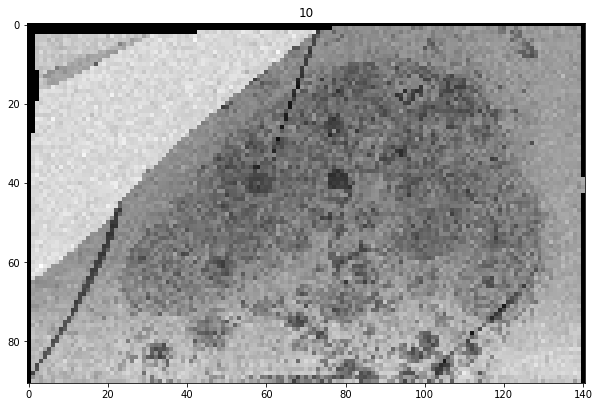

In [5]:
r = resolutions[-1]
a0 = darrays[r][0, 0, 0, :, :]
plt.figure(figsize=(10, 10))
plt.imshow(a0, cmap='gray')
plt.title(r);

As you can see it very low resolution, so let's look at the 3rd smallest resolution instead.

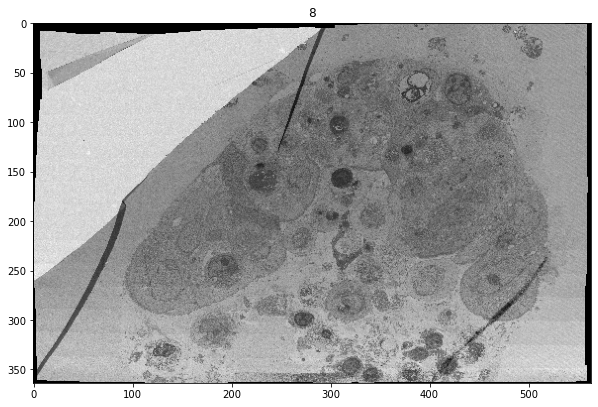

In [6]:
r = resolutions[-3]
a0 = darrays[r][0, 0, 0, :, :]
plt.figure(figsize=(10, 10))
plt.imshow(a0, cmap='gray')
plt.title(r);

Now "zoom in" to the centre of image by showing the same number of pixels but at the next resolution up

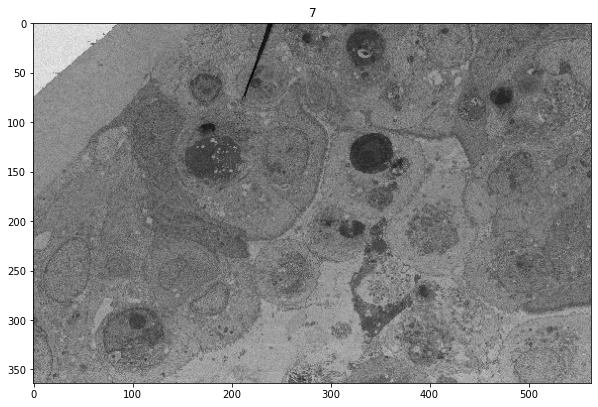

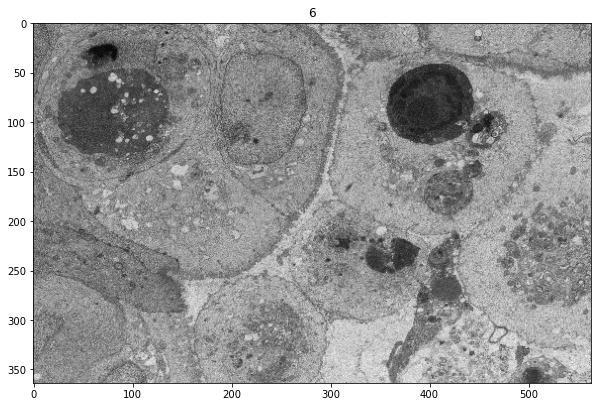

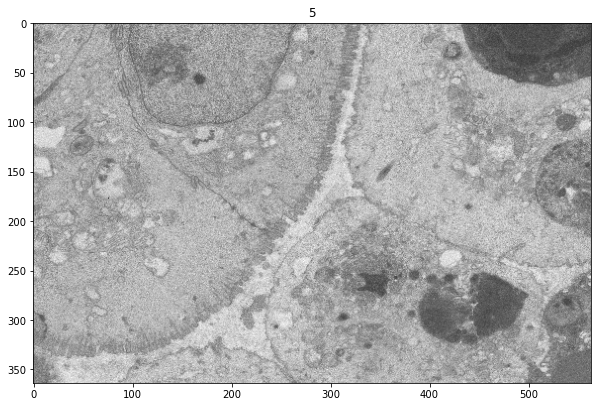

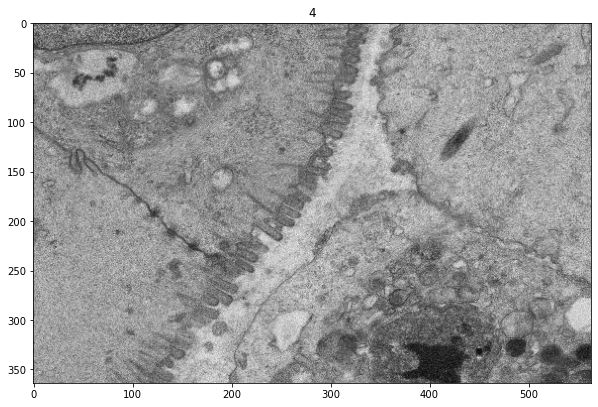

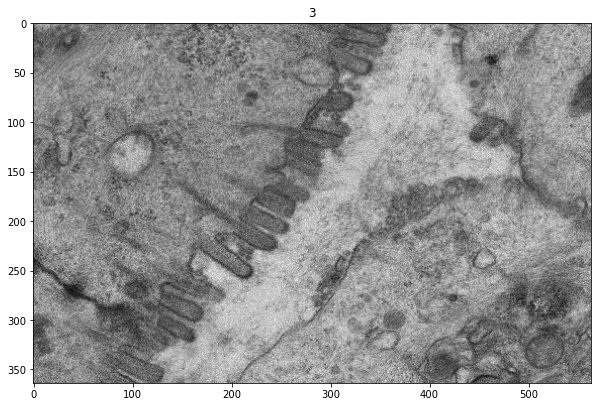

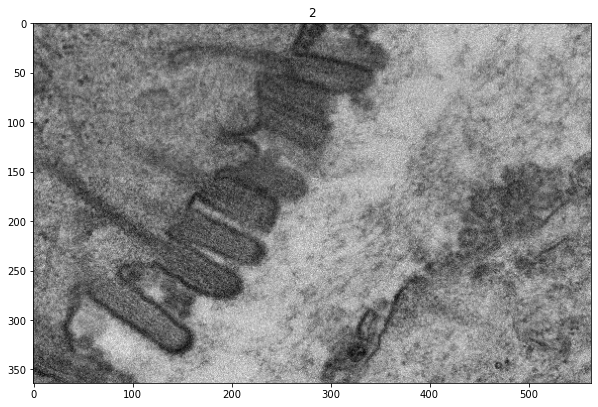

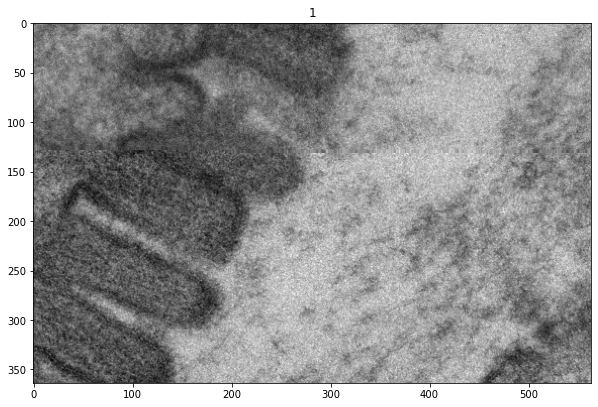

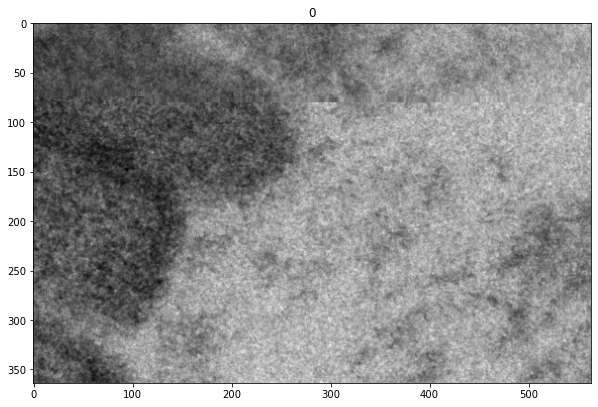

In [7]:
dy = int(a0.shape[0] / 2)
dx = int(a0.shape[1] / 2)

for r in reversed(resolutions[:-3]):
    a = darrays[r][0, 0, 0, :, :]
    # Change the following line to zoom into a different location
    cy, cx = int(a.shape[0] / 2), int(a.shape[1] / 2)
    region = a[cy-dy:cy+dy, cx-dx:cx+dx]
    plt.figure(figsize=(10, 10))
    plt.imshow(a[cy-dy:cy+dy, cx-dx:cx+dx], cmap='gray')
    plt.title(r)
    plt.show()

### License
Copyright (C) 2020 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.